## Imports, Load Data and Configuration

In [1]:
%cd ..
# do this once on top level so we can call imports from src

C:\Users\reighns\reighns_ml\ml_projects\aiap_batch10_coronary_artery_disease


In [17]:
import random
import sqlite3
from dataclasses import asdict, dataclass, field
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union, Callable
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr, spearmanr
from sklearn import (
    decomposition,
    ensemble,
    manifold,
    preprocessing,
    dummy,
    ensemble,
    linear_model,
    tree,
    svm,
    neighbors,
    model_selection
)
import sklearn

# can show pipeline
sklearn.set_config(display="diagram")

In [18]:
@dataclass
class config:
    raw_data: str = "data/survive.db"
    processed_data: str = ""
    X_test_path: str = "data/X_test.csv"
    y_test_path: str = "data/y_test.csv"
    model_results_df_path: str = "data/model_results_df.csv"

    seed: int = 1992
    classification_type: str = "binary"
    classifiers = [
        # baseline model
        dummy.DummyClassifier(random_state=1992, strategy="stratified"),
        # linear model
        linear_model.LogisticRegression(random_state=1992, solver="liblinear"),
        # SVM
        svm.SVC(probability=True, random_state=config.seed),
        # nearest neighbours
        neighbors.KNeighborsClassifier(n_neighbors=8),
        # tree
        tree.DecisionTreeClassifier(random_state=1992),
        # ensemble
        ensemble.RandomForestClassifier(n_estimators=10, random_state=1992),
    ]

    cv_params: Dict[str, Any] = field(
        default_factory=lambda: {
            "cv_schema": "StratifiedGroupKFold",
            "num_folds": 6,
            "train_size": 0.9,
            "shuffle": True,
            "group_kfold_split": "ID",
            "seed": 1992,
        }
    )
    nominal_feats: List[str] = field(default_factory=lambda: ["Gender"])
    ordinal_feats: List[str] = field(
        default_factory=lambda: ["Smoke", "Diabetes", "Ejection Fraction"]
    )
    categorical_feats: List[str] = field(
        default_factory=lambda: [
            "Gender",
            "Smoke",
            "Diabetes",
            "Ejection Fraction",
        ]
    )
    continuous_feats: List[str] = field(
        default_factory=lambda: [
            "Age",
            "Sodium",
            "Creatinine",
            "Platelets",
            "Creatine phosphokinase",
            "Blood Pressure",
            "Hemoglobin",
            "Height",
            "Weight",
        ]
    )

    predictor_cols: List[str] = field(
        default_factory=lambda: [
            "Gender",
            "Smoke",
            "Diabetes",
            "Ejection Fraction",
            "Age",
            "Sodium",
            "Creatinine",
            "Platelets",
            "Creatine phosphokinase",
            "Blood Pressure",
            "Hemoglobin",
            "Height",
            "Weight",
        ]
    )

    target_col: str = "Survive"

    unwanted_cols: List[str] = field(
        default_factory=lambda: ["ID", "Favorite color"]
    )

    # metrics
    monitored_metric: str = "multiclass_roc_auc_score"

    # Plotting
    target_colors: List[str] = field(
        default_factory=lambda: ["#fe4a49", "#59981A"]
    )

    def to_dict(self) -> Dict[str, Any]:
        """Convert the config object to a dictionary.

        Returns:
            Dict: The config object as a dictionary.
        """

        return asdict(self)

    def to_yaml(self, filepath: Union[str, Path]) -> str:
        """Convert the config object to a YAML string and write to file.

        Args:
            filepath (Union[str, Path]): The filepath to write the YAML string to.

        Returns:
            str: The config object as YAML string.
        """
        return yaml.dump(self.to_dict(), filepath)


We use the `config` defined here instead from my scripts to allow some flexibility in experimentation.

In [19]:
config = config()

Import my scripts from `src`.

In [20]:
from src import make_folds, metrics_results, models, preprocess, train, utils

In [21]:
utils.seed_all(seed = config.seed)

Using Seed Number 1992


In [22]:
# Load the data using sqlite3
df = preprocess.read_sqlite_file(
    db_file=config.raw_data,
    sql_query="SELECT * FROM survive",
    path_to_save="survive.csv",
)

# Clean the data.
df = preprocess.clean_df(df)

## Model Selection, Training and Evaluation

### Cross-Validation and Resampling Strategy

!!! warning "Generalization"
    > Ultimately, we are interested in the Generalization Error made by the model, that is, how well the model perform on <b>unseen data</b> that is not taken from our sample set $\mathcal{D}$. In general, we use <b>validation set</b> for <b>Model Selection</b> and the <b>test set</b> for <b>an estimate of generalization error</b> on new data.
            <br> <b>- Refactored from Elements of Statistical Learning, Chapter 7.2</b></p>

#### Step 1: Train-Test-Split

I did not use train-test split from scikit-learn because it does not have a split by group. Since we have decided we want to **stratify** by **groups** then we should ensure our test set is split this way. I will therefore use `StratifiedGroupKFold` and split our dataset into $6$ folds where I take the last ($6$) fold as the "hidden test (unseen) set". In this case, our test set is also **stratified and grouped**.

We note that this is a relatively small dataset and in practice, we need a large sample size to get a reliable/stable split, it is also recommended to retrain the whole dataset (without the "unseen" test set) after we have done the model selection process (eg. finding best hyperparameters). 

#### Step 2: Resampling Strategy

Note that we will be performing `StratifiedGroupKFold` as our resampling strategy. After our split in Step 1, we have a training set $X_{\text{train}}$, we will then perform our resampling strategy on this $X_{\text{train}}$. We will choose our choice of $K = 5$. The choice of $K$ is somewhat arbitrary, and is derived [empirically](https://stats.stackexchange.com/questions/61783/bias-and-variance-in-leave-one-out-vs-k-fold-cross-validation).

#### Cross-Validation Workflow

To recap, we have the following:

- **Training Set ($X_{\text{train}}$)**: This will be further split into K validation sets during our cross-validation. This set is used to fit a particular hypothesis $h \in \mathcal{H}$.
- **Validation Set ($X_{\text{val}}$)**: This is split from our $X_{\text{train}}$ during cross-validation. This set is used for model selection (i.e. find best hyperparameters, attempt to produce a best hypothesis $g \in \mathcal{H}$).
- **Test Set ($X_{\text{test}}$)**: This is an unseen test set, and we will only use it after we finish tuning our model/hypothesis. Suppose we have a final best model $g$, we will use $g$ to predict on the test set to get an estimate of the generalization error (also called out-of-sample error).

---

<figure>
<img src='https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/breast-cancer-wisconsin/data/images/grid_search_workflow.png' width="500"/>
<figcaption align = "center"><b>Courtesy of scikit-learn on a typical Cross-Validation workflow.</b></figcaption>
</figure>

In [23]:
# Split the data into train and test sets.
df_folds = make_folds.make_folds(df, config=config)

# Drop columns that are not needed for training.
df_folds = preprocess.drop_columns(df_folds, config=config)

# 3-way cv-split, but did not use sklearn's native train_test_split because no option to use groups.
# stratifying alone may lead to a bias in the test set with data leakage. So use this temporary workaround.

X_train_and_valid, X_test = (
    df_folds[df_folds["fold"] != 6].reset_index(drop=True),
    df_folds[df_folds["fold"] == 6].reset_index(drop=True),
)
X_test, y_test = X_test.copy(), X_test.pop(config.target_col)

fold  Survive
1     0          1722
      1           775
2     0          1692
      1           814
3     0          1684
      1           821
4     0          1694
      1           804
5     0          1702
      1           805
6     0          1691
      1           796
dtype: int64


We can check that the folds are **stratified and grouped**.

### Preliminary Model Selection and Algorithm Spot-Checking

#### Preliminary Model Selection (Model Design and Choice) (Importance of EDA)

Though the phrase **Model Selection** can also be used in conjunction with **Model Evaluation**, we follow Nick and Kevin's Ace the Data Science Interview book and define it as such:

- First let us clear the air and understand that we can use cross-validation and **select the models** after seeing the performance on the evaluation set. But we go one step back and think of model design and choice. After all, if you do not have the resources, then it does not make sense to try out **all models and see which perform the best**.
- Thus, we need to filter out and choose some model first.

> Given business constraints, evaluation metrics and data sources, you need to ask yourself which kind of models fulfill these criterion and make the most sense to try. Factors to consider when selecting model design is:

- Training and prediction speed: Linear models are fast and NNs are slow.
- Interpretability? Do we need interpretability on the model or black box with good performance suffice?
- EDA's importance:
    - Dimensionality: Does your data suffer from too many variables? If yes, may consider PCA, and even after PCA or similar techniques still a lot of features, then models like KNN (with distance metrics) may not be considered unless customized.
    - Categorical and Numerical Features: One-hot encode features for linear models, but for tree models, it is generally ok to handle them.
    - Feature Scaling: Tells us that some models are sensitive to scale (KNN again), so if we want to use KNN, we need to scale it appropriately.
    
For more details, see ML cheat sheet in the book.

- read here too: https://scikit-learn.org/dev/tutorial/machine_learning_map/index.html

#### Preprocessing Pipeline

<div class="alert alert-block alert-danger">
<b>Say No to Data Leakage:</b> This has been emphasized throughout and we must be careful as we should never touch the test set when fitting the model. In fact, we should try our best to not <b>contaminate</b> our validation set as well.
    <li> This means that preprocessing steps such as <code>StandardScaling()</code> should only be fitted on the training data, and then apply the same transformation (mean and std) on the test data. In other words, do not apply scaling on the whole dataset before splitting. 
    <li> However, it is also equally important to take note <b>not to contaminate</b> our validation set, which is often overlooked, resulting in over optimistic results from model selection phase, but perform badly on unseen test set. As a result, when we use a 5 fold cross validation, we should be careful during fitting that the preprocessing steps are only applied on the training folds, and not on all 5 folds.
    <li> The same idea is also applied to our <code>ReduceVIF()</code> preprocessing step. We should also include this in our pipeline and not select the features outside the cross-validation loop.</li>
</div>   

---

Quoting from **[scikit-learn](https://scikit-learn.org/stable/common_pitfalls.html)**:

> Data leakage occurs when information that would not be available at prediction time is used when building the model. This results in overly optimistic performance estimates, for example from [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation), and thus poorer performance when the model is used on actually novel data, for example during production.

> A common cause is not keeping the test and train data subsets separate. Test data should never be used to make choices about the model. **The general rule is to never call fit on the test data.** While this may sound obvious, this is easy to miss in some cases, for example when applying certain pre-processing steps.

> Although both train and test data subsets should receive the same preprocessing transformation (as described in the previous section), it is important that these transformations are only learnt from the training data. For example, if you have a normalization step where you divide by the average value, the average should be the average of the train subset, not the average of all the data. If the test subset is included in the average calculation, information from the test subset is influencing the model.


---

<div class="alert alert-success" role="alert">
    <b>How to avoid Data Leakage?</b> We know the pitfalls of fitting on validation/test data, the natural question is how can we avoid it completely? You can code it up yourself, but as a starter, we can use scikit-learn's <code>Pipeline</code> object. My tips are as follows:
<li> Any preprocessing step must be done after splitting the whole dataset into train and test. If you are also using cross-validation, then we should only apply the preprocessing steps on the train set, and then use the metrics obtained from the train set to transform the validation set. You can see my pseudo-code below for a rough outline.
    <li> The <code>Pipeline</code> object of Scikit-Learn can help prevent data leakage.
</div>

In [24]:
# Preprocessing pipeline
preprocessor = preprocess.preprocessing_pipeline(config=config)
preprocessor

ColumnTransformer(transformers=[('numeric_transformer',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Sodium', 'Creatinine', 'Platelets',
                                  'Creatine phosphokinase', 'Blood Pressure',
                                  'Hemoglobin', 'Height', 'Weight']),
                                ('categorical_transformer',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'Smoke', 'Diabetes',
                                  'Ejection Fraction'])])

#### Algorithm Spot-Checking

<div class="alert alert-success" role="alert">
    <b>Terminology Alert!</b> This method is advocated by <a href="https://machinelearningmastery.com/">Jason Brownlee PhD</a> and this serves as the first stage of my modelling process. We will rapidly test (spot check) different classifier algorithms, from <code>DummyClassifier</code>, to <code>LinearModel</code> to more sophisticated ensemble trees like <code>RandomForest</code>. 
</div>

---

I also note to the readers that we need to think of a few things when choosing the "optimal" machine learning algorithm:

- [No Lunch Free Theorem](https://en.wikipedia.org/wiki/No_free_lunch_theorem) intuitively says that no single optimization algorithm can work best in all situations. Therefore, spot checking can help us form a basis of which algorithm might work better in this particular scenario.
- [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor) often appears in many Machine Learning textbook, and the narrative is that a simpler model more often times generalizes better than a complex model. This is not unfamiliar when we think of the bias-variance tradeoff, and that is why there is always a tradeoff that we must make.

#### Pseudo-Code of Cross-Validation and Pipeline

The below outlines a pseudo code of the cross-validation scheme using `Pipeline` object. Note that I included the most outer loop, which is searching for hyperparameters.

- Define $G$ as the set of combination of hyperparamters. Define number of splits to be $K$.
- For each set of hyperparameter $z \in Z$:
    - for fold $j$ in K:
        - Set $F_{\text{train}}=\bigcup\limits_{i\neq k}^{K} F_{i}$
        - Set $F_{\text{val}} = F_{j}$ as the validation set
        - Perform Standard Scaling on $F_{\text{train}}$ and find the mean and std
        - Perform VIF recursively on $F_{\text{train}}$ and find the selected features
        - Transform $F_{\text{val}}$ using the mean and std found using $F_{\text{train}}$
        - Transform $F_{\text{val}}$ to have only the selected features from $F_{\text{train}}$
        - Train and fit on $F_{\text{train}}$ 
    - Evaluate the fitted parameters on $F_{\text{val}}$ to obtain $\mathcal{M}$

In [25]:
# Return classifiers that is now a pipeline
classifiers_with_pipeline_dict = models.return_classifiers_with_pipeline(
    preprocessor=preprocessor, config=config
)

In [26]:
model_results_dict = train.train_on_fold(
    X_train_and_valid,
    pipeline_dict=classifiers_with_pipeline_dict,
    num_folds=5,
    config=config,
)

#### Comparison of Cross-Validated Models (CV + OOF)

The point of the following comparison is to check how different models are performing across folds. More specifically, if we have 5 folds, we will have a metric score for each fold, subsequently, we can find the standard error of model's performance. We need to be aware of models that have high variance across folds in terms of the metrics performance. This can indicate that the model is highly unstable, and may be a sign of overfitting.

> OOF are useful during ensembling, i.e. hill climbing technique elaborate.

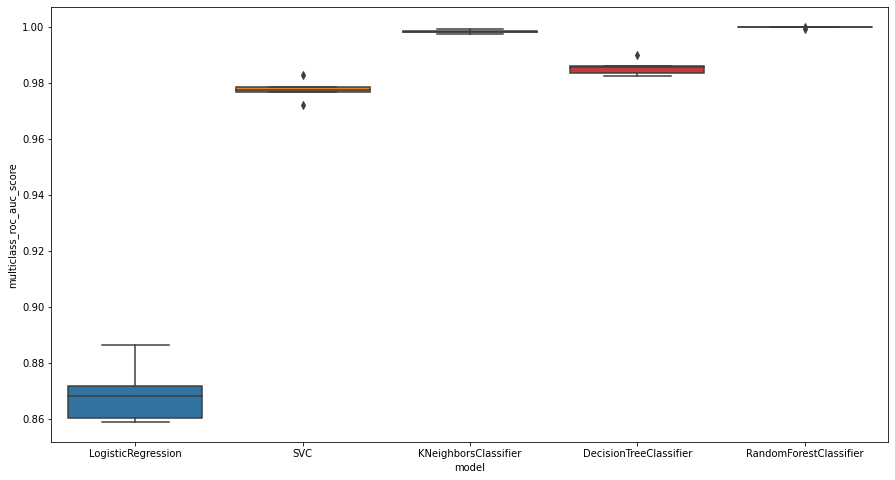

,model,fold,multiclass_roc_auc_score
26,DecisionTreeClassifier,fold 3,0.989814
27,DecisionTreeClassifier,fold 4,0.985886
28,DecisionTreeClassifier,fold 5,0.985555
29,DecisionTreeClassifier,SE,0.001281
30,RandomForestClassifier,fold 1,0.999981
31,RandomForestClassifier,fold 2,0.999983
32,RandomForestClassifier,fold 3,0.999221
33,RandomForestClassifier,fold 4,0.999979
34,RandomForestClassifier,fold 5,0.999993
35,RandomForestClassifier,SE,0.000153


In [27]:
plot_boxplot = True

# Takes in a model_dict and add cv results to the dict
model_results_dict_with_summary = {
    model: metrics_results.add_cv_results(model_results)
    for model, model_results in model_results_dict.items()
}

# Transforms model_dict_with_summary to a Dict of dataframes
# model_results_df['LogisticRegression'] -> df
model_results_df = {
    name: results.to_dataframe().T
    for name, results in model_results_dict_with_summary.items()
}
model_results_df = pd.concat(model_results_df, axis=0)

# TODO: Fix-hardcoded column names, is it necessary to hardcode?
model_results_df.columns = [
    "fold 1",
    "fold 2",
    "fold 3",
    "fold 4",
    "fold 5",
    "mean_cv",
    "std_cv",
    "oof_cv",
]

if plot_boxplot:
    summary_df = metrics_results.summarize_metrics(
        model_results_dict=model_results_dict,
        metric_name=config.monitored_metric,
    )
    
    display(summary_df.tail(10))

#### Out-of-Fold Confusion Matrix (TODO: Fix color issues)

We do have information on the performance of each folds, we now look at the performance of all 5 folds together. Typicall there are two ways to do it, one is to simply take the average of the score of five folds, the other is to take a look at out of folds predictions.

---

From the confusion matrix of the out of fold performance, Logistic Regression does seem to be a model we can explore on, although slightly lower in terms of overall AUROC score than SVC, it seems to have the quite low False Negatives amongst all. With further hyperparameter tuning and threshold optimization, we can make it better.

In [28]:
plot_confusion_matrix = True

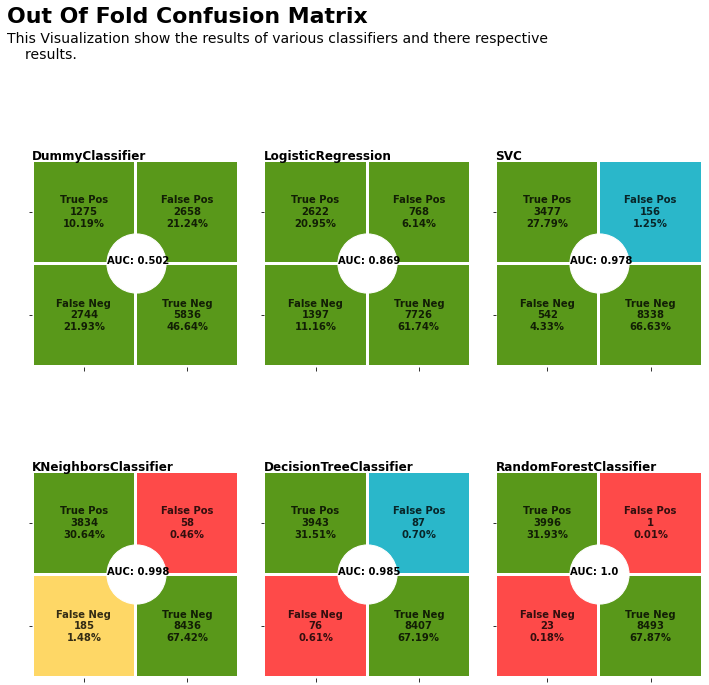

In [29]:
if plot_confusion_matrix:
    model_names = list(model_results_dict.keys())
    metrics_results.plot_binary_confusion_matrix(
        model_results_df, model_names
    )

#### Hypothesis Testing Across Models (TODO after AIAP)

I am slightly shocked at the performance of plain `LogisticRegression`, I decide to use an idea from [Hypothesis Testing Across Models](http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_kfold_cv/) to check if the difference is really by chance or not. Note that I will be modifying his code as his code does not split using StratifiedKFold.

---

The basic idea is to test if two model's difference in scores (in this case roc), is statistically significant or not. However, we note that this method may violate an assumption of Student's t test.

---

- Null Hypothesis $H_0$: The difference in the performance score of two classifiers is Statistically Significant.
- Alternate Hypothesis $H_1$: The difference in the performance score of two classifiers is **not** Statistically Significant.

In [15]:
# def paired_ttest_skfold_cv(
#     estimator1: Callable,
#     estimator2: Callable,
#     X: np.ndarray,
#     y: np.ndarray,
#     cv: int = 10,
#     scoring: str = None,
#     shuffle: bool = False,
#     random_seed: int = None,
# ) -> float:
#     """Modified from https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/ttest.py to accomodate StratifiedKFold.

#     Args:
#         estimator1 (Callable): [description]
#         estimator2 (Callable): [description]
#         X (np.ndarray): [description]
#         y (np.ndarray): [description]
#         cv (int, optional): [description]. Defaults to 10.
#         scoring (str, optional): [description]. Defaults to None.
#         shuffle (bool, optional): [description]. Defaults to False.
#         random_seed (int, optional): [description]. Defaults to None.

#     Raises:
#         AttributeError: [description]

#     Returns:
#         float: [description]
#     """
#     if not shuffle:
#         skf = model_selection.StratifiedKFold(n_splits=cv, shuffle=shuffle)
#     else:
#         skf = model_selection.StratifiedKFold(
#             n_splits=cv, random_state=random_seed, shuffle=shuffle
#         )

#     if scoring is None:
#         if estimator1._estimator_type == "classifier":
#             scoring = "accuracy"
#         elif estimator1._estimator_type == "regressor":
#             scoring = "r2"
#         else:
#             raise AttributeError("Estimator must " "be a Classifier or Regressor.")
#     if isinstance(scoring, str):
#         scorer = metrics.get_scorer(scoring)
#     else:
#         scorer = scoring

#     score_diff = []

#     for train_index, test_index in skf.split(X=X, y=y):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]

#         estimator1.fit(X_train, y_train)
#         estimator2.fit(X_train, y_train)

#         est1_score = scorer(estimator1, X_test, y_test)
#         est2_score = scorer(estimator2, X_test, y_test)
#         score_diff.append(est1_score - est2_score)

#     avg_diff = np.mean(score_diff)

#     numerator = avg_diff * np.sqrt(cv)
#     denominator = np.sqrt(
#         sum([(diff - avg_diff) ** 2 for diff in score_diff]) / (cv - 1)
#     )
#     t_stat = numerator / denominator

#     pvalue = stats.t.sf(np.abs(t_stat), cv - 1) * 2.0
#     return float(t_stat), float(pvalue)


In [16]:
# # check if difference between algorithms is real
# X_tmp = df_folds[predictor_cols].values
# y_tmp = df_folds['diagnosis'].values

# t, p = paired_ttest_skfold_cv(estimator1=classifiers[1], estimator2=classifiers[-1],shuffle=True,cv=5, X=X_tmp, y=y_tmp, scoring='roc_auc', random_seed=config.seed)

In [17]:
# logger.info('P-value: %.3f, t-Statistic: %.3f' % (p, t))

### Model Evaluation and Hyperparameter Tuning

#### Model Selection (Part 2): Hyperparameter Tuning with GridSearchCV

Here we are no longer talking about our model choice and design, here we already chose a few models for training, and after training, we need to select the best hyperparameters for those models.

!!! success "Hyperparameter Tuning"
    We have done a quick spot checking on algorithms and realized that `LogisticRegression` is doing well for this task. For this purpose, I will just perform hyperparameter tuning on this single algorithm. However, in practice and if resources are allowed, I will also tune other models such as `RandomForest()`, or gradient boosting algorithms such as `XGBoost`, as I believe they will perform no worse than our Logistic Regression model given the right hyperparameters.


---

!!! info "Grid Search is the Gwei?"
    Meh! We will use an old-fashioned way to search for hyperparameters, which is brute force method. The time complexity of Grid Search is high and if you have many hyperparameters to tune, I recommend trying out <b>Random Grid Search</b> or libraries like <b>Optuna</b> that uses Bayesian Optimization.

---

!!! note "TODO"
    Try to code up your own `GridSearchCV` to have maximum flexibility.

##### Make Finetuning Pipeline

The following `make_finetuning_pipeline` does exactly the same thing is as `make_pipeline` earlier. The only difference is we can pass in flexible list of steps to the pipeline from outside.

In [30]:
# Return classifiers that is now a pipeline
finetuning_classifiers_with_pipeline_dict = models.return_classifiers_with_pipeline(
    preprocessor=preprocessor, config=config
)

# not interested in finetuning dummy
del finetuning_classifiers_with_pipeline_dict["DummyClassifier"]

In [31]:
@dataclass
class ModelForTuning:
    model: Callable
    param_grid: Dict

In [32]:
models_for_tuning_list = [
    ModelForTuning(
        model=linear_model.LogisticRegression(
            solver="saga",
            random_state=config.seed,
            max_iter=10000,
            n_jobs=-1,
            fit_intercept=True,
        ),
        param_grid=dict(
            model__penalty=["l1", "l2"],
            model__C=np.logspace(-4, 4, 10),
        ),
    ),
    ModelForTuning(
        model=tree.DecisionTreeClassifier(random_state=config.seed),
        param_grid=dict(
            model__max_depth=[2, 3, 5, 10, 20],
            model__min_samples_leaf=[5, 10, 20, 50, 100],
            model__criterion=["gini", "entropy"],
        ),
    ),
    ModelForTuning(
        model=ensemble.RandomForestClassifier(n_estimators=10),
        param_grid=dict(
            model__max_depth=[3, 6, None],
        ),
    ),
]

Modify when have time to take in steps.

In [33]:
def optimize_models(
    models_list: List[ModelForTuning],
    X_train: np.ndarray,
    y_train: np.ndarray,
    scorer: Union[str, Callable] = None,
    steps: List[Tuple[str, Callable]] = None,
) -> List[Callable]:
    """Optimize models in models_list using X_train and y_train.
    We are using GridSearchCV to find the best parameters for each model.
    Consider using Optuna for hyperparameter optimization (or wandb for hyperparameter optimization).

    Args:
        models_list (List[ModelForTuning]): List of models to optimize.
        X_train (np.ndarray): X_train data.
        y_train (np.ndarray): y_train data.

    Returns:
        grids (List[Callable]): List of optimized models.
    """
    # @ TODO: make a scoring list to pass in so we can evaluate multiple metrics.
    grids = []
    for model_for_tuning in models_for_tuning_list:
        model_name = model_for_tuning.model.__class__.__name__
        param_grid = model_for_tuning.param_grid
        pipeline_ = finetuning_classifiers_with_pipeline_dict[model_name]
        grid = model_selection.GridSearchCV(
                pipeline_,
                param_grid=param_grid,
                cv=5,
                refit=True,
                verbose=1,
                scoring=scorer,
                n_jobs=-1,
            )
        grids.append(grid)

    for grid in grids:
        grid.fit(X_train, y_train)

    return grids

In [34]:
roc_auc_scorer = "roc_auc_ovr" 
# Unsure why this gives much lower score - to investigate
# metrics.make_scorer(metrics.roc_auc_score, average="macro", multi_class='ovr')

In [35]:
X_train, y_train = X_train_and_valid[config.predictor_cols], X_train_and_valid[config.target_col]

In [36]:
grids = optimize_models(models_for_tuning_list, X_train, y_train, scorer=roc_auc_scorer)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [37]:
# For example, we can see Logistic Regression's GridSearchCV
# results like this.
grid_cv_df = pd.DataFrame(grids[0].cv_results_)
display(grid_cv_df.loc[grid_cv_df['rank_test_score']==1])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.064203,0.005194,0.011207,0.000717,166.810054,l1,"{'model__C': 166.81005372000558, 'model__penal...",0.874185,0.877626,0.86919,0.860597,0.864495,0.869219,0.006197,1


In [38]:
# For example, we can see DT GridSearchCV
# results like this.
grid_cv_df = pd.DataFrame(grids[1].cv_results_)
display(grid_cv_df.loc[grid_cv_df['rank_test_score']==1])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
45,0.0661,0.005769,0.007978,0.000002,entropy,20,5,"{'model__criterion': 'entropy', 'model__max_de...",0.99088,0.986214,0.992496,0.993286,0.991689,0.990913,0.002483,1


In [39]:
# For example, we can see RF GridSearchCV
# results like this.
grid_cv_df = pd.DataFrame(grids[2].cv_results_)
display(grid_cv_df.loc[grid_cv_df['rank_test_score']==1])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.094945,0.006351,0.006981,3.568323e-07,None,{'model__max_depth': None},1.0,0.999996,0.999998,0.999972,0.999966,0.999986,0.000015,1


In [40]:
def return_grid_df(
    grids: List[model_selection.GridSearchCV],
) -> Union[pd.DataFrame, List[model_selection.GridSearchCV]]:
    """Return a dataframe of the grids with shorted names.

    Args:
        grids (List[model_selection.GridSearchCV]): A list of GridSearchCV models that are tuned.

    Returns:
        grid_df, grids (Union[pd.DataFrame, List[model_selection.GridSearchCV]]): A dataframe of the grids with shorted names.
    """

    def shorten_param(param_name):
        if "__" in param_name:
            return param_name.rsplit("__", 1)[1]
        return param_name

    grid_df = []
    for grid in grids:
        model_name = grid.estimator["model"].__class__.__name__
        cv_results = pd.DataFrame(grid.cv_results_).sort_values(
            "mean_test_score", ascending=False
        )

        # get the parameter names
        column_results = [f"param_{name}" for name in grid.param_grid.keys()]
        column_results += [
            "mean_test_score",
            "std_test_score",
            "rank_test_score",
        ]
        cv_results = cv_results[column_results]
        cv_results = cv_results.rename(shorten_param, axis=1)
        cv_results["model_name"] = model_name
        grid_df.append(cv_results)

    return grid_df, grids

In [41]:
# grid_df and grids should necessarily be in the same sequence.
# grid_df[0] == grids[0] in terms of model information, in this
# case, the first index of both should be logistic regression.
grid_df, grids = return_grid_df(grids)

In [42]:
grids[0]

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric_transformer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Sodium',
                                                                          'Creatinine',
                                                                          'Platelets',
                                                                          'Creatine '
                                                                          'phosphokinase',
                                                                          'Blood '
                                                                          'Pressure',
                                                                          'Hemoglobin',
                                                                          'Height',
                                                                          'Weight']),
                                                                        ('categorical_transformer',
                                                                         Pipeline(steps=[...
                                                                          'Diabetes',
                                                                          'Ejection '
                                                                          'Fraction'])])),
                                       ('model',
                                        LogisticRegression(random_state=1992,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'model__C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'model__penalty': ['l1', 'l2']},
             scoring='roc_auc_ovr', verbose=1)

In [43]:
for model_df, grid in zip(grid_df, grids):
    best_hyperparams_df = model_df.iloc[[0]]
    model_name = best_hyperparams_df.model_name.unique()[0]
    # logger.info(f"Best hyperparameters found for {model_name} is as follows:\n{grid.best_params_}")
    display(best_hyperparams_df)
    print()

,penalty,C,mean_test_score,std_test_score,rank_test_score,model_name
14,l1,166.810054,0.869219,0.006197,1,LogisticRegression


,max_depth,min_samples_leaf,criterion,mean_test_score,std_test_score,rank_test_score,model_name
45,20,5,entropy,0.990913,0.002483,1,DecisionTreeClassifier


,max_depth,mean_test_score,std_test_score,rank_test_score,model_name
2,None,0.999986,0.000015,1,RandomForestClassifier


!!! success
    Our best performing set of hyperparameters for Logistic Regression `{'model__C': 0.3593813663804626, 'model__penalty': 'l1'}` gives rise to a mean cross validation score of $0.995419$, which is higher than the model with default hyperparameter scoring, $0.995$ by a small margin. Not too surprising for Logistic Regression here since there aren't many things to tune, and should not see major improvements, but for Decesion Tree, it has increased from 0.907 to around 0.95, seeing quite a big jump with tuned params.

!!! danger "DANGERRRRRRRRRRRRR"
    I am being a bit hand wavy in terms of comparison here, I assumed THAT `GridSearchCV` used the exact same splitting strategy (yes it uses `StratifiedKFold` here) with the exact **SEED/RANDOM_STATE**, which I cannot promise as of now. Thus, a different splitting will, unfortunately, result in different results, although, I don't expect by a huge margin - so I think it is a no-go to compare like this.
    We can probably pass in a cv function into `GridSearchCV` to ensure seeding. 
    This also highlights a problem that even K-fold splitting does not guarantee the reduction in variance. 

!!! sucess "Room for Improvement"
    Apart from the other methods to search for the optimal hyperparameters, we can also include preprocessing step as a tunable hyperparameter. More specifically, in our `ReduceVIF()` step, we hard coded two manual criterion in which the algorithm will stop; if the threshold reaches 10, or if the number of features removed hit 20; we can include them in the search space so we do not need to worry about how many features to remove!

#### Model Retrain with Hyperparameters on whole Train

- Page 30 ish thereabout see Sebastian's Model Evaluation paper Model Evaluation, Model Selection, and Algorithm:
    - The last step usually is retrain train + valid.

!!! info "Retraining Methods"
    From the discussion[^cpmp], my doubts are cleared. Quoting verbatim from the discussion, we have:

K-folds cross validation was devised as a way to assess model performance using training data. A great paper on this from Sebastian Raschka is a must read https://arxiv.org/abs/1811.12808. You use K-folds cv to tune you model, then retrain on all training data with best hyperparamters found.

However, once you have run K-fold cv, you get $K$ trained models. Kagglers quickly found that ensembling these models was giving good results at zero computation cost, rather than having to retrain a model on full data. It soon became a very common practice.

---

!!! note "Takeway"
    For small-medium datasets, after finding the best hyperparameters $G$, we use $G$ in our model $h$ to train on the whole dataset $\mathcal{X}$ again to get the fitted parameters of $h$. Then you use the newly gained fitted parameters to then evaluate on the **Test Set**.
    For large and computationally expensive datasets, when you finished your K-folds, say 5 folds, you get 5 "different" models, $h_{i}, i \in {1, 2, 3, 4, 5}$, what you can do is to save the weights (or in normal ML, weights refer to the parameters gained), and evaluate on the test set for each of the five models, you then get 5 different test predictions, and a common practice is the do a simple mean of these 5 set of predictions. 



[^cpmp]: https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/275883

##### Retrain on K-Folds

TODO: This should be easy for me as I dabbled more in Kaggle comp and are more familiar with this methodology.

##### Retrain on the whole training set

A common practice after the hyperparameter tuning phase is to retrain the model on the whole dataset $X_{\text{train}}$ where we will get the estimator's coefficients obtained from the retraining. This is actually already done as the scikit-learn's `GridSearchCV` has a parameter `refit`; if we select it to be true, then after the model selection process is done (i.e. getting the best hyperparameters after cross validation with grid search), the grid search object will retrain on the whole $X_{\text{train}}$ with the best hyperparameters internally, and return us back an object in which we can call `predict` etc.

!!! warning "Paranoia Alert"

    However, to be extra careful, we can retrain manually using the best hyperparameters and check if scikit-learn is true to its documentation. We will just reconstruct the pipeline using the grid's best hyper parameters. We will then test if the retrained model's coefficients coincide with the grid's best estimator's coefficients. If there difference is 0, this means they are trained under the same circumstances and we can be sure that the refit parameter is behaving true to its words.

    ```python
    grid_best_hyperparams = grid.best_params_
    print(grid_best_hyperparams) ->
    {'model__C': 0.3593813663804626, 'model__penalty': 'l1'}
    ```

In [44]:
# Return classifiers that is now a pipeline
retrain_classifiers_with_pipeline_dict = models.return_classifiers_with_pipeline(
    preprocessor=preprocessor, config=config
)

# not interested in finetuning dummy
del retrain_classifiers_with_pipeline_dict["DummyClassifier"]

##### LR Retrained

In [45]:
retrain_lr_pipeline = classifiers_with_pipeline_dict["LogisticRegression"]
retrain_lr_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Sodium',
                                                   'Creatinine', 'Platelets',
                                                   'Creatine phosphokinase',
                                                   'Blood Pressure',
                                                   'Hemoglobin', 'Height',
                                                   'Weight']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Smoke',
                                                   'Diabetes',
                                                   'Ejection Fraction'])])),
                ('model',
                 LogisticRegression(random_state=1992, solver='liblinear'))])

##### LR Decision Boundary

https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression

##### DT Retrained

In [34]:
retrain_dt_pipeline = classifiers_with_pipeline_dict["DecisionTreeClassifier"]
retrain_dt_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Sodium',
                                                   'Creatinine', 'Platelets',
                                                   'Creatine phosphokinase',
                                                   'Blood Pressure',
                                                   'Hemoglobin', 'Height',
                                                   'Weight']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Smoke',
                                                   'Diabetes',
                                                   'Ejection Fraction'])])),
                ('model', DecisionTreeClassifier(random_state=1992))])

##### DT Plot Tree

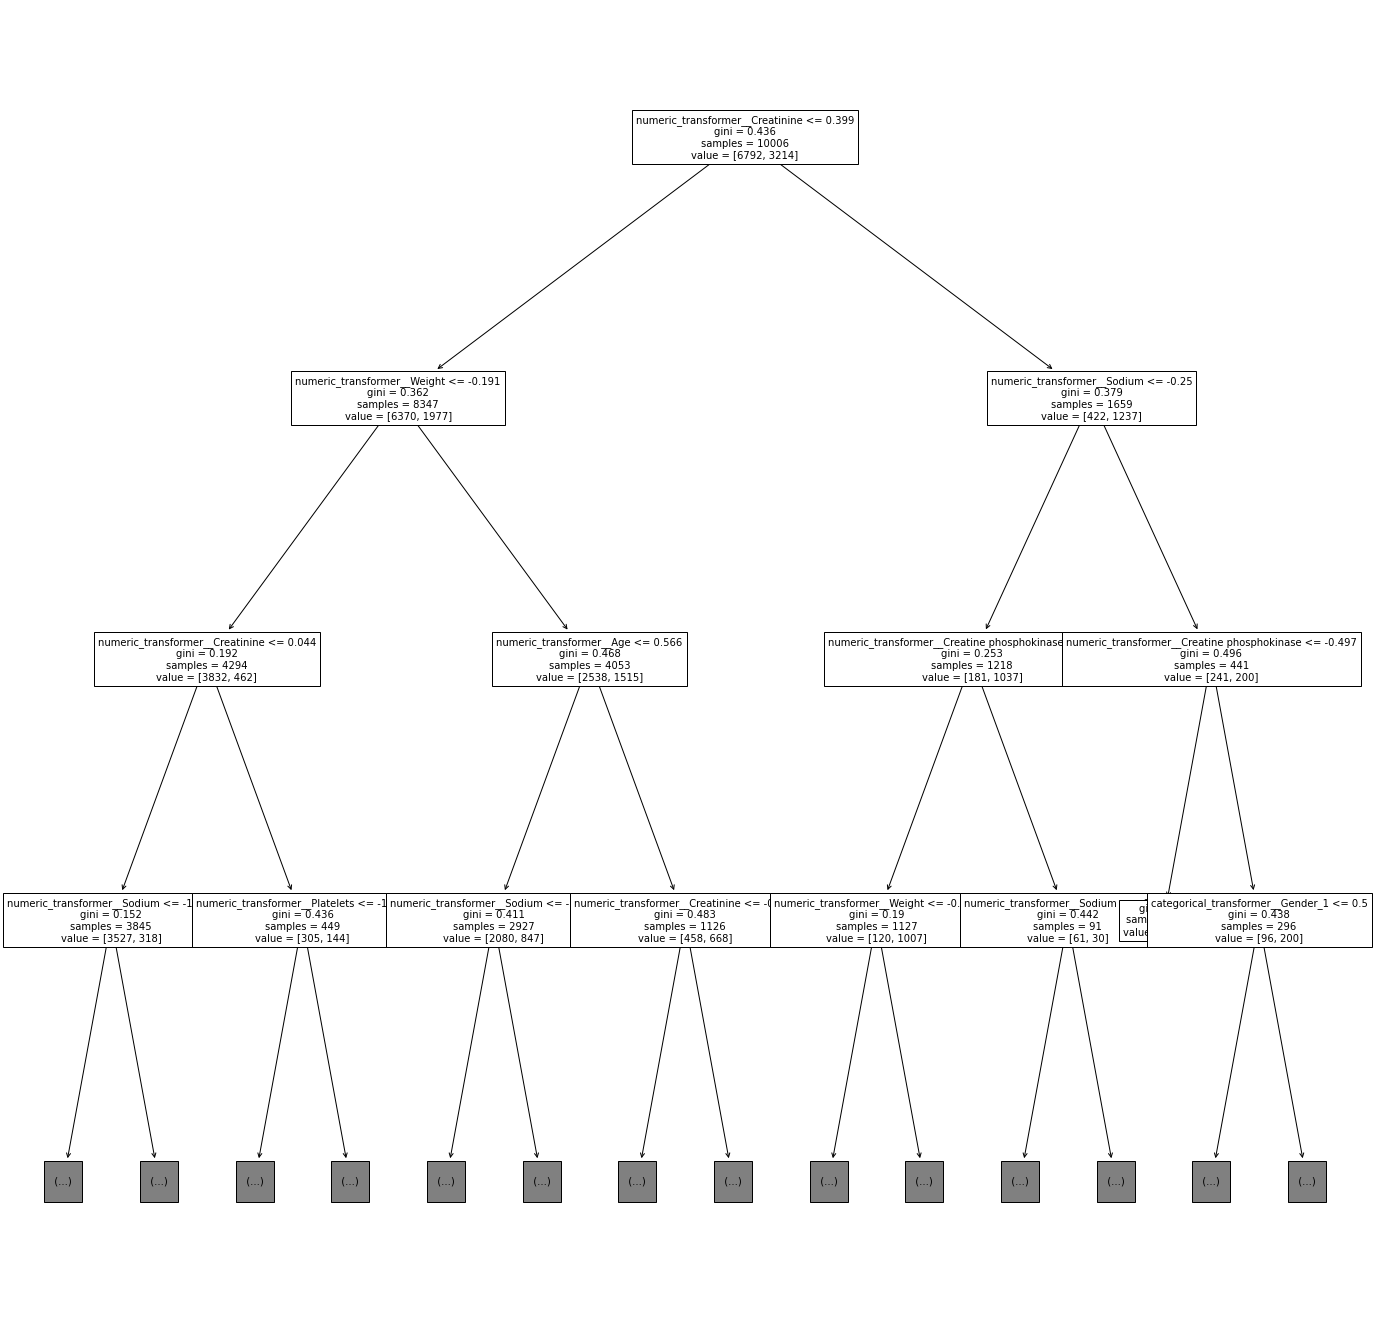

In [46]:
# plot tree
plt.figure(figsize=(24, 24))  # set plot size (denoted in inches)
sklearn.tree.plot_tree(retrain_dt_pipeline["model"], max_depth = 3, feature_names = list(feature_columns), fontsize=10)
plt.show()


##### DT Feature Names and Importance

Hack to get features names out of pipeline object cause one hot encoded so cannot just take from df. https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer

In [38]:
feature_columns = retrain_dt_pipeline["preprocessor"].get_feature_names_out()

In [39]:
retrain_dt_pipeline["model"].feature_importances_

array([0.09166871, 0.10362914, 0.25938572, 0.12569358, 0.16468277,
       0.01163998, 0.01371003, 0.03271491, 0.11143199, 0.00501543,
       0.01258085, 0.02773394, 0.02148256, 0.        , 0.01783839,
       0.        , 0.        , 0.        , 0.000792  ])

##### DT Decision Boundary

- https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html

##### RF Retrained

In [ ]:
retrain_rf_pipeline = retrain_classifiers_with_pipeline_dict["RandomForestClassifier"]

_ = retrain_rf_pipeline.fit(X_train, y_train)

### Model Persistence (Saving Models)

[Model Persistence](https://scikit-learn.org/stable/modules/model_persistence.html)

We save our models using `joblib` and we can load it back any time. 

!!! note
    Save it to wandb or GCP storage to store models for better consistency.

In [ ]:
model_path = "/content/"

def save_model(grids: List[Callable], path: str):
    """Save a model to a file"""
    for grid in grids:
        model_name = grid.best_estimator_["model"].__class__.__name__
        path_to_save = Path(path, f"{model_name}_grid.joblib")
        # Dump to local path
        dump(grid, Path(path, path_to_save))
        # Dump to wandb cloud
        # "model.h5" is saved in wandb.run.dir & will be uploaded at the end of training
        wandb.save(os.path.join(wandb.run.dir, path_to_save))

Save the model!

#### Wandb

We first see how we save and load using wandb.

In [ ]:
save_model(grids, model_path)

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


In [ ]:
logistic_path = "LogisticRegression_grid.joblib"

In [ ]:
# restore the model file "model.h5" from a specific run by user "lavanyashukla"
# in project "save_and_restore" from run "10pr4joa"
best_model = wandb.restore(logistic_path)


# use the "name" attribute of the returned object
# if your framework expects a filename, e.g. as in Keras
# model.load_weights(best_model.name)

#### Joblib

We see how we use `joblib` to save and load.

Load the model, and we can test it now if our loaded models is predicting correctly!

In [ ]:
logistic_grid = load("/content/LogisticRegression_grid.joblib")

Great it seems to work!

#### Sanity Check

!!! note
    We just make sure our loaded weight from path is the same as the one we trained. We can easily compare predictions (or coefficients) by the following.

In [ ]:
load(best_model.name).predict(X_train).all() == logistic_grid.predict(
    X_train
).all() == grids[0].predict(X_train).all()

True

In [ ]:
metrics.roc_auc_score(
    y_train, logistic_grid.predict_proba(X_train)[:, 1]
) == metrics.roc_auc_score(
    y_train, grids[0].predict_proba(X_train)[:, 1]
) == metrics.roc_auc_score(
    y_train, load(best_model.name).predict_proba(X_train)[:, 1]
)


True

Seems like the save and load method works perfectly.

!!! warning
    Do not call this directly.
    ```python
    grids[0].best_estimator_["model"].predict(X_train)
    ```

    This is because `grids[0].best_estimator_["model"]` is only referring to the Logistic Regression Model WITHOUT the pipeline (preprocessing) steps. And hence will raise error if the preprocessing steps has feature selection. But the main idea is, be careful when using the above.

In [ ]:
# grids[0].best_estimator_["model"].predict(X_train)